To begin copy this notebook to your own drive:

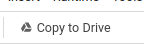


### Submission Instructions:
1. **Restart the kernel** (in the menubar, select Runtime$\rightarrow$Restart runtime)
2. **Download the notebook** (in the menubar, select File$\rightarrow$Download .ipynb)
3. **Upload the downloaded notebook (.ipynb file) to your repository**.


Make sure you fill in any place that says `YOUR CODE HERE`, and that no tests fail.  

Note: To use a GPU, do the following: Runtime$\rightarrow$Change runtime type$\rightarrow$ GPU

In [ ]:
import gdown
import nltk
gdown.download('https://drive.google.com/uc?export=download&id=1PFOG06NEsTL6VieKQjMk1oNzyzcUtiWn', 'glove.npy', quiet=False)
gdown.download('https://drive.google.com/uc?export=download&id=1-3SxpirQjmX-RCRyRjKdP2L7G_tNgp00', 'vocab.json', quiet=False)

nltk.download('punkt')

Downloading...
From: https://drive.google.com/uc?export=download&id=1PFOG06NEsTL6VieKQjMk1oNzyzcUtiWn
To: /content/glove.npy
100%|██████████| 480M/480M [00:01<00:00, 250MB/s]
Downloading...
From: https://drive.google.com/uc?export=download&id=1-3SxpirQjmX-RCRyRjKdP2L7G_tNgp00
To: /content/vocab.json
100%|██████████| 7.69M/7.69M [00:00<00:00, 244MB/s]
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
!pip install datasets
!pip uninstall -y transformers accelerate
!pip install transformers accelerate
!pip install git+https://github.com/huggingface/accelerate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 28.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 16.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 53.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 26.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 33.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 21.4 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 70.5 MB/s eta 0:00

In [ ]:
import numpy as np
from datasets import load_dataset


raw_datasets = load_dataset("imdb")


  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:

from nltk.tokenize import word_tokenize
import json

with open("vocab.json") as f:
  vocab = json.load(f)

def tokenize_function(example):
  sentences = [x.lower() for x in example['text']]
  tokenized_sentences = [word_tokenize(x) for x in sentences]
  tokenized_idx = [[vocab[word] if word in vocab else vocab["unk"] for word in x] for x in tokenized_sentences]
  max_size = max([len(x) for x in tokenized_idx])
  final_tokenized_idx = tokenized_idx

  return {"labels":example['label'],'input_ids':final_tokenized_idx}

In [ ]:
small_train_dataset = raw_datasets['train'].shuffle(seed=42).map(tokenize_function,batched=True)
small_eval_dataset = raw_datasets['test'].shuffle(seed=42).map(tokenize_function,batched=True)

In [ ]:
def pad_sequence_to_length(
    sequence,
    desired_length: int,
    default_value = lambda: 0,
    padding_on_right: bool = True,
):
    sequence = list(sequence)
    # Truncates the sequence to the desired length.
    if padding_on_right:
        padded_sequence = sequence[:desired_length]
    else:
        padded_sequence = sequence[-desired_length:]
    # Continues to pad with default_value() until we reach the desired length.
    pad_length = desired_length - len(padded_sequence)
    # This just creates the default value once, so if it's a list, and if it gets mutated
    # later, it could cause subtle bugs. But the risk there is low, and this is much faster.
    values_to_pad = [default_value()] * pad_length
    if padding_on_right:
        padded_sequence = padded_sequence + values_to_pad
    else:
        padded_sequence = values_to_pad + padded_sequence
    return padded_sequence

In [ ]:
from datasets import load_metric

metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    logits = eval_pred.predictions
    labels = eval_pred.label_ids
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

<ipython-input-11-c6aba47c7ef1>:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")


In [ ]:
from dataclasses import dataclass

@dataclass
class DataCollatorWithPadding:
  
  def __call__(self, features):
    features_dict={}
    if "labels" in features[0]:
        
      features_dict["labels"] = torch.tensor([x.pop("labels") for x in features]).long()

    input_ids = [x.pop("input_ids") for x in features]
    max_len = max(len(x) for x in input_ids)
    masks = [[1]*len(x) for x in input_ids]
    
    features_dict["input_ids"] = torch.tensor([pad_sequence_to_length(x,max_len) for x in input_ids]).long()
    features_dict["attention_masks"] = torch.tensor([pad_sequence_to_length(x,max_len) for x in masks]).long()

    return features_dict


In [ ]:
from torch import nn
import torch
from torch.distributions.bernoulli import Bernoulli

#Use nn.Sequential and nn.Linear for the network, and nn.CrossEntropyLoss for the loss.
#Make sure that the final layer has output dimension of size 2.
class DAN(nn.Module):
  def __init__(self, num_hidden_layers, dropout, activation):
          super().__init__()
          self.num_labels = 2
          self.embeddings = nn.Embedding.from_pretrained(torch.FloatTensor(np.load("glove.npy")))
          emd_dims = 300
          hidden_dims = 300
          # YOUR CODE HERE
          self.dropout = dropout
          model = []
          model.append(nn.Linear(emd_dims, hidden_dims))
          model.append(activation)
          for i in range(num_hidden_layers):
            model.append(nn.Linear(hidden_dims, hidden_dims))
            model.append(activation)
          model.append(nn.Linear(hidden_dims, self.num_labels))
          model.append(nn.Softmax(dim=1))
          self.classifier = nn.Sequential(*model)
          self.loss = nn.CrossEntropyLoss()
          # END YOUR END
          


  def forward(self,input_ids,attention_masks,labels=None,**kwargs):
      # YOUR CODE HERE
      masked_embs = input_ids * attention_masks
      x = self.embeddings(masked_embs)      
      rw = Bernoulli(1-self.dropout).sample((x.shape[1], ))
      x = x[:, rw==1]
      avg = torch.mean(x, 1) 
      # END YOUR END
      res = self.classifier(avg)
      loss = self.loss(res, labels)
      return {"loss":loss,"logits":res}



In [ ]:
#Hint: You may want to look at https://huggingface.co/transformers/main_classes/callback.html
from transformers import Trainer
from transformers import TrainingArguments

co = DataCollatorWithPadding()

def configure_model(num_train_epochs, num_hidden_layers, dropout, activation):
  training_args = TrainingArguments("DAN",
                                    # YOUR CODE HERE
                                    num_train_epochs=num_train_epochs, #must be at least 10.
                                    per_device_train_batch_size=40,
                                    per_device_eval_batch_size=40,
                                    learning_rate=0.001,
                                    # END YOUR END
                    
                                    save_total_limit=2,
                                    log_level="error",
                                    evaluation_strategy="epoch")
  
  model = DAN(num_hidden_layers, dropout, activation)    

  trainer = Trainer(
      model=model,
      data_collator=co,
      args=training_args,
      callbacks = [
                  # YOUR CODE HERE

                  # END YOUR END
      ],
      train_dataset=small_train_dataset,
      eval_dataset=small_eval_dataset,
      compute_metrics=compute_metrics,
  )
  filename = f"model_{num_train_epochs}_{num_hidden_layers}_{dropout}_{activation}"
  torch.save(model.state_dict(), f"models/{filename}")
  return trainer


In [ ]:
import matplotlib.pyplot as plt

def plot_accuracy(num_train_epochs, trainer, title):
  accuracies = []
  for l in trainer.state.log_history:
    if 'eval_accuracy' in l:
      accuracies.append(l['eval_accuracy'])
  epochs = range(1, num_train_epochs+1)
  plt.plot(epochs, accuracies)
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy")
  plt.ylim([.70, .84])
  plt.title(title)
  plt.show()


In [ ]:
def plot_by_slice(slice_data, slice_title, trainers):
  accuracies = []
  for t in trainers:
    a = []
    for l in t.state.log_history:
      if 'eval_accuracy' in l:
        a.append(l['eval_accuracy'])
    accuracies.append(max(a))
  plt.plot(slice_data, accuracies)
  plt.xlabel(slice_title)
  plt.ylabel("Accuracy")
  plt.ylim([.77, .84])
  plt.title(f"{slice_title} Accuracy")
  plt.show()

In [ ]:
!mkdir models

## 5.b

{'loss': 0.5689, 'learning_rate': 0.000968, 'epoch': 0.8}
{'eval_loss': 0.5802783370018005, 'eval_accuracy': 0.71868, 'eval_runtime': 11.266, 'eval_samples_per_second': 2219.058, 'eval_steps_per_second': 55.476, 'epoch': 1.0}
{'loss': 0.5007, 'learning_rate': 0.0009360000000000001, 'epoch': 1.6}
{'eval_loss': 0.4846876859664917, 'eval_accuracy': 0.81956, 'eval_runtime': 10.972, 'eval_samples_per_second': 2278.525, 'eval_steps_per_second': 56.963, 'epoch': 2.0}
{'loss': 0.4981, 'learning_rate': 0.0009040000000000001, 'epoch': 2.4}
{'eval_loss': 0.5180813074111938, 'eval_accuracy': 0.78536, 'eval_runtime': 11.1423, 'eval_samples_per_second': 2243.71, 'eval_steps_per_second': 56.093, 'epoch': 3.0}
{'loss': 0.4979, 'learning_rate': 0.000872, 'epoch': 3.2}
{'loss': 0.4837, 'learning_rate': 0.00084, 'epoch': 4.0}
{'eval_loss': 0.49509289860725403, 'eval_accuracy': 0.80892, 'eval_runtime': 10.8294, 'eval_samples_per_second': 2308.527, 'eval_steps_per_second': 57.713, 'epoch': 4.0}
{'loss': 0.

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'loss': 0.5626, 'learning_rate': 0.000968, 'epoch': 0.8}
{'eval_loss': 0.4951950013637543, 'eval_accuracy': 0.80912, 'eval_runtime': 11.9992, 'eval_samples_per_second': 2083.475, 'eval_steps_per_second': 52.087, 'epoch': 1.0}
{'loss': 0.5012, 'learning_rate': 0.0009360000000000001, 'epoch': 1.6}
{'eval_loss': 0.49351149797439575, 'eval_accuracy': 0.8098, 'eval_runtime': 12.0093, 'eval_samples_per_second': 2081.714, 'eval_steps_per_second': 52.043, 'epoch': 2.0}
{'loss': 0.5067, 'learning_rate': 0.0009040000000000001, 'epoch': 2.4}
{'eval_loss': 0.48968324065208435, 'eval_accuracy': 0.81484, 'eval_runtime': 11.9739, 'eval_samples_per_second': 2087.87, 'eval_steps_per_second': 52.197, 'epoch': 3.0}
{'loss': 0.4952, 'learning_rate': 0.000872, 'epoch': 3.2}
{'loss': 0.4902, 'learning_rate': 0.00084, 'epoch': 4.0}
{'eval_loss': 0.4890108108520508, 'eval_accuracy': 0.81544, 'eval_runtime': 11.9789, 'eval_samples_per_second': 2086.997, 'eval_steps_per_second': 52.175, 'epoch': 4.0}
{'loss': 

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'loss': 0.5694, 'learning_rate': 0.000968, 'epoch': 0.8}
{'eval_loss': 0.5006513595581055, 'eval_accuracy': 0.80312, 'eval_runtime': 11.9128, 'eval_samples_per_second': 2098.574, 'eval_steps_per_second': 52.464, 'epoch': 1.0}
{'loss': 0.5064, 'learning_rate': 0.0009360000000000001, 'epoch': 1.6}
{'eval_loss': 0.5212997794151306, 'eval_accuracy': 0.78128, 'eval_runtime': 11.8352, 'eval_samples_per_second': 2112.34, 'eval_steps_per_second': 52.809, 'epoch': 2.0}
{'loss': 0.5098, 'learning_rate': 0.0009040000000000001, 'epoch': 2.4}
{'eval_loss': 0.4942399859428406, 'eval_accuracy': 0.81048, 'eval_runtime': 11.8459, 'eval_samples_per_second': 2110.439, 'eval_steps_per_second': 52.761, 'epoch': 3.0}
{'loss': 0.5011, 'learning_rate': 0.000872, 'epoch': 3.2}
{'loss': 0.4972, 'learning_rate': 0.00084, 'epoch': 4.0}
{'eval_loss': 0.5062692761421204, 'eval_accuracy': 0.79576, 'eval_runtime': 11.8064, 'eval_samples_per_second': 2117.502, 'eval_steps_per_second': 52.938, 'epoch': 4.0}
{'loss': 0

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'loss': 0.5729, 'learning_rate': 0.000968, 'epoch': 0.8}
{'eval_loss': 0.5072635412216187, 'eval_accuracy': 0.79568, 'eval_runtime': 11.8347, 'eval_samples_per_second': 2112.433, 'eval_steps_per_second': 52.811, 'epoch': 1.0}
{'loss': 0.5204, 'learning_rate': 0.0009360000000000001, 'epoch': 1.6}
{'eval_loss': 0.501420795917511, 'eval_accuracy': 0.80288, 'eval_runtime': 11.8286, 'eval_samples_per_second': 2113.522, 'eval_steps_per_second': 52.838, 'epoch': 2.0}
{'loss': 0.5137, 'learning_rate': 0.0009040000000000001, 'epoch': 2.4}
{'eval_loss': 0.5156015753746033, 'eval_accuracy': 0.7852, 'eval_runtime': 11.7582, 'eval_samples_per_second': 2126.172, 'eval_steps_per_second': 53.154, 'epoch': 3.0}
{'loss': 0.5081, 'learning_rate': 0.000872, 'epoch': 3.2}
{'loss': 0.5024, 'learning_rate': 0.00084, 'epoch': 4.0}
{'eval_loss': 0.5218493342399597, 'eval_accuracy': 0.78132, 'eval_runtime': 11.8348, 'eval_samples_per_second': 2112.409, 'eval_steps_per_second': 52.81, 'epoch': 4.0}
{'loss': 0.5

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'loss': 0.5786, 'learning_rate': 0.000968, 'epoch': 0.8}
{'eval_loss': 0.514853298664093, 'eval_accuracy': 0.78616, 'eval_runtime': 11.827, 'eval_samples_per_second': 2113.806, 'eval_steps_per_second': 52.845, 'epoch': 1.0}
{'loss': 0.5157, 'learning_rate': 0.0009360000000000001, 'epoch': 1.6}
{'eval_loss': 0.5561536550521851, 'eval_accuracy': 0.74436, 'eval_runtime': 11.4197, 'eval_samples_per_second': 2189.196, 'eval_steps_per_second': 54.73, 'epoch': 2.0}
{'loss': 0.5243, 'learning_rate': 0.0009040000000000001, 'epoch': 2.4}
{'eval_loss': 0.5259444713592529, 'eval_accuracy': 0.77652, 'eval_runtime': 10.6361, 'eval_samples_per_second': 2350.477, 'eval_steps_per_second': 58.762, 'epoch': 3.0}
{'loss': 0.5108, 'learning_rate': 0.000872, 'epoch': 3.2}
{'loss': 0.5108, 'learning_rate': 0.00084, 'epoch': 4.0}
{'eval_loss': 0.5188289284706116, 'eval_accuracy': 0.78312, 'eval_runtime': 11.245, 'eval_samples_per_second': 2223.218, 'eval_steps_per_second': 55.58, 'epoch': 4.0}
{'loss': 0.509

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'loss': 0.5854, 'learning_rate': 0.000968, 'epoch': 0.8}
{'eval_loss': 0.5442653298377991, 'eval_accuracy': 0.7528, 'eval_runtime': 10.5455, 'eval_samples_per_second': 2370.671, 'eval_steps_per_second': 59.267, 'epoch': 1.0}
{'loss': 0.5305, 'learning_rate': 0.0009360000000000001, 'epoch': 1.6}
{'eval_loss': 0.5336672067642212, 'eval_accuracy': 0.76724, 'eval_runtime': 10.9261, 'eval_samples_per_second': 2288.106, 'eval_steps_per_second': 57.203, 'epoch': 2.0}
{'loss': 0.5338, 'learning_rate': 0.0009040000000000001, 'epoch': 2.4}
{'eval_loss': 0.5521189570426941, 'eval_accuracy': 0.74732, 'eval_runtime': 11.6341, 'eval_samples_per_second': 2148.86, 'eval_steps_per_second': 53.722, 'epoch': 3.0}
{'loss': 0.5219, 'learning_rate': 0.000872, 'epoch': 3.2}
{'loss': 0.5205, 'learning_rate': 0.00084, 'epoch': 4.0}
{'eval_loss': 0.518530011177063, 'eval_accuracy': 0.7822, 'eval_runtime': 11.4003, 'eval_samples_per_second': 2192.927, 'eval_steps_per_second': 54.823, 'epoch': 4.0}
{'loss': 0.51

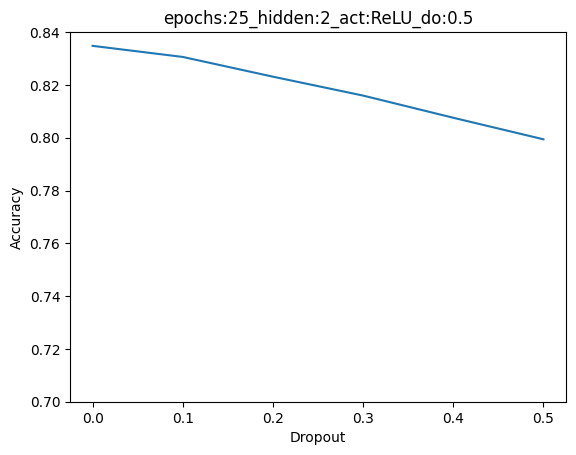

In [ ]:
dropouts = [0, 0.1, 0.2, 0.3, 0.4, 0.5]
do_trainers = []

for d in dropouts:
  num_train_epochs=25
  num_hidden_layers=2
  activation="ReLU"
  title = f"epochs:{num_train_epochs}_hidden:{num_hidden_layers}_act:{activation}_do:{d}"
  trainer = configure_model(num_train_epochs=num_train_epochs, num_hidden_layers=num_hidden_layers, dropout=d, activation=nn.ReLU())
  trainer.train()
  do_trainers.append(trainer)

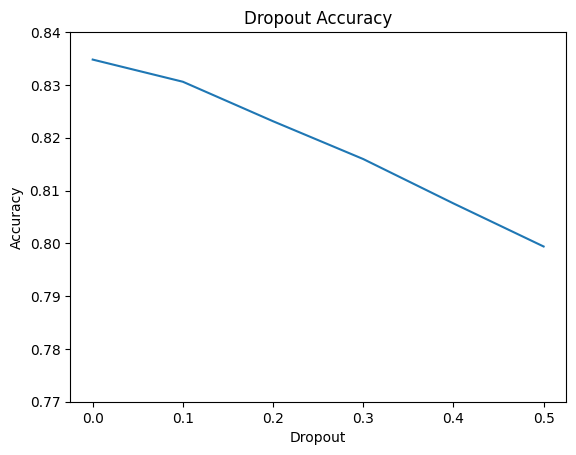

In [ ]:
plot_by_slice(dropouts, "Dropout", do_trainers)

## 5.c

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'loss': 0.6125, 'learning_rate': 0.000968, 'epoch': 0.8}
{'eval_loss': 0.5350884199142456, 'eval_accuracy': 0.79372, 'eval_runtime': 13.3648, 'eval_samples_per_second': 1870.579, 'eval_steps_per_second': 46.764, 'epoch': 1.0}
{'loss': 0.5235, 'learning_rate': 0.0009360000000000001, 'epoch': 1.6}
{'eval_loss': 0.5051016807556152, 'eval_accuracy': 0.80964, 'eval_runtime': 12.218, 'eval_samples_per_second': 2046.17, 'eval_steps_per_second': 51.154, 'epoch': 2.0}
{'loss': 0.5069, 'learning_rate': 0.0009040000000000001, 'epoch': 2.4}
{'eval_loss': 0.5124723315238953, 'eval_accuracy': 0.79384, 'eval_runtime': 12.2979, 'eval_samples_per_second': 2032.872, 'eval_steps_per_second': 50.822, 'epoch': 3.0}
{'loss': 0.4961, 'learning_rate': 0.000872, 'epoch': 3.2}
{'loss': 0.49, 'learning_rate': 0.00084, 'epoch': 4.0}
{'eval_loss': 0.4896445572376251, 'eval_accuracy': 0.81884, 'eval_runtime': 12.357, 'eval_samples_per_second': 2023.148, 'eval_steps_per_second': 50.579, 'epoch': 4.0}
{'loss': 0.486

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'loss': 0.5694, 'learning_rate': 0.000968, 'epoch': 0.8}
{'eval_loss': 0.4948839843273163, 'eval_accuracy': 0.811, 'eval_runtime': 11.0805, 'eval_samples_per_second': 2256.218, 'eval_steps_per_second': 56.405, 'epoch': 1.0}
{'loss': 0.4959, 'learning_rate': 0.0009360000000000001, 'epoch': 1.6}
{'eval_loss': 0.5020118951797485, 'eval_accuracy': 0.80192, 'eval_runtime': 11.4406, 'eval_samples_per_second': 2185.198, 'eval_steps_per_second': 54.63, 'epoch': 2.0}
{'loss': 0.4959, 'learning_rate': 0.0009040000000000001, 'epoch': 2.4}
{'eval_loss': 0.523392915725708, 'eval_accuracy': 0.77948, 'eval_runtime': 12.0075, 'eval_samples_per_second': 2082.028, 'eval_steps_per_second': 52.051, 'epoch': 3.0}
{'loss': 0.4884, 'learning_rate': 0.000872, 'epoch': 3.2}
{'loss': 0.4811, 'learning_rate': 0.00084, 'epoch': 4.0}
{'eval_loss': 0.4811305105686188, 'eval_accuracy': 0.82408, 'eval_runtime': 11.5793, 'eval_samples_per_second': 2159.029, 'eval_steps_per_second': 53.976, 'epoch': 4.0}
{'loss': 0.48

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'loss': 0.5609, 'learning_rate': 0.000968, 'epoch': 0.8}
{'eval_loss': 0.49765563011169434, 'eval_accuracy': 0.80516, 'eval_runtime': 11.3229, 'eval_samples_per_second': 2207.918, 'eval_steps_per_second': 55.198, 'epoch': 1.0}
{'loss': 0.4998, 'learning_rate': 0.0009360000000000001, 'epoch': 1.6}
{'eval_loss': 0.49553555250167847, 'eval_accuracy': 0.80808, 'eval_runtime': 11.7096, 'eval_samples_per_second': 2135.009, 'eval_steps_per_second': 53.375, 'epoch': 2.0}
{'loss': 0.501, 'learning_rate': 0.0009040000000000001, 'epoch': 2.4}
{'eval_loss': 0.523464560508728, 'eval_accuracy': 0.77956, 'eval_runtime': 11.4128, 'eval_samples_per_second': 2190.52, 'eval_steps_per_second': 54.763, 'epoch': 3.0}
{'loss': 0.4956, 'learning_rate': 0.000872, 'epoch': 3.2}
{'loss': 0.4863, 'learning_rate': 0.00084, 'epoch': 4.0}
{'eval_loss': 0.4943045377731323, 'eval_accuracy': 0.80904, 'eval_runtime': 12.331, 'eval_samples_per_second': 2027.41, 'eval_steps_per_second': 50.685, 'epoch': 4.0}
{'loss': 0.4

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'loss': 0.5736, 'learning_rate': 0.000968, 'epoch': 0.8}
{'eval_loss': 0.49608317017555237, 'eval_accuracy': 0.80876, 'eval_runtime': 12.3205, 'eval_samples_per_second': 2029.142, 'eval_steps_per_second': 50.729, 'epoch': 1.0}
{'loss': 0.5043, 'learning_rate': 0.0009360000000000001, 'epoch': 1.6}
{'eval_loss': 0.4896816313266754, 'eval_accuracy': 0.81484, 'eval_runtime': 12.1443, 'eval_samples_per_second': 2058.571, 'eval_steps_per_second': 51.464, 'epoch': 2.0}
{'loss': 0.5042, 'learning_rate': 0.0009040000000000001, 'epoch': 2.4}
{'eval_loss': 0.4948062598705292, 'eval_accuracy': 0.807, 'eval_runtime': 12.1284, 'eval_samples_per_second': 2061.277, 'eval_steps_per_second': 51.532, 'epoch': 3.0}
{'loss': 0.4906, 'learning_rate': 0.000872, 'epoch': 3.2}
{'loss': 0.4817, 'learning_rate': 0.00084, 'epoch': 4.0}
{'eval_loss': 0.5063704252243042, 'eval_accuracy': 0.79792, 'eval_runtime': 11.4156, 'eval_samples_per_second': 2189.994, 'eval_steps_per_second': 54.75, 'epoch': 4.0}
{'loss': 0.

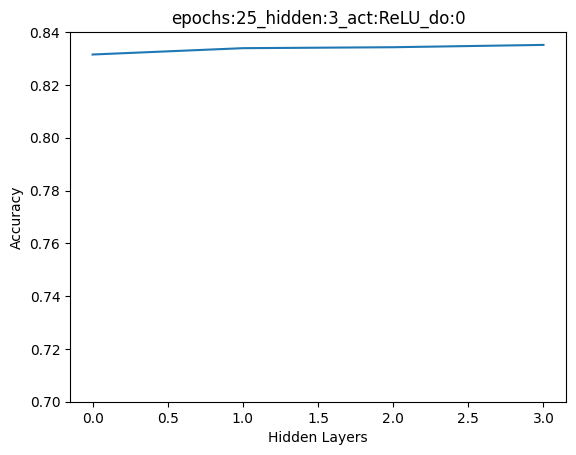

In [ ]:
hidden_layers = list(range(0, 4))
  
hl_trainers = []
for h in hidden_layers: 
  num_train_epochs=25
  num_hidden_layers=h
  activation="ReLU"
  title = f"epochs:{num_train_epochs}_hidden:{h}_act:{activation}_do:{0}"
  trainer = configure_model(num_train_epochs=num_train_epochs, num_hidden_layers=num_hidden_layers, dropout=0, activation=nn.ReLU())
  trainer.train()
  hl_trainers.append(trainer)

plot_by_slice(hidden_layers, "Hidden Layers", hl_trainers)

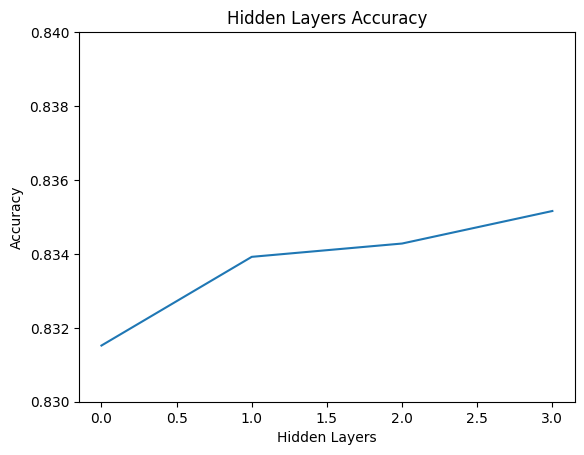

In [ ]:
plot_by_slice(hidden_layers, "Hidden Layers", hl_trainers)

## 5.d

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'loss': 0.5609, 'learning_rate': 0.000968, 'epoch': 0.8}
{'eval_loss': 0.49765563011169434, 'eval_accuracy': 0.80516, 'eval_runtime': 11.1584, 'eval_samples_per_second': 2240.468, 'eval_steps_per_second': 56.012, 'epoch': 1.0}
{'loss': 0.4998, 'learning_rate': 0.0009360000000000001, 'epoch': 1.6}
{'eval_loss': 0.49553555250167847, 'eval_accuracy': 0.80808, 'eval_runtime': 11.2183, 'eval_samples_per_second': 2228.511, 'eval_steps_per_second': 55.713, 'epoch': 2.0}
{'loss': 0.501, 'learning_rate': 0.0009040000000000001, 'epoch': 2.4}
{'eval_loss': 0.523464560508728, 'eval_accuracy': 0.77956, 'eval_runtime': 11.1798, 'eval_samples_per_second': 2236.168, 'eval_steps_per_second': 55.904, 'epoch': 3.0}
{'loss': 0.4956, 'learning_rate': 0.000872, 'epoch': 3.2}
{'loss': 0.4863, 'learning_rate': 0.00084, 'epoch': 4.0}
{'eval_loss': 0.4943045377731323, 'eval_accuracy': 0.80904, 'eval_runtime': 11.1712, 'eval_samples_per_second': 2237.898, 'eval_steps_per_second': 55.947, 'epoch': 4.0}
{'loss': 

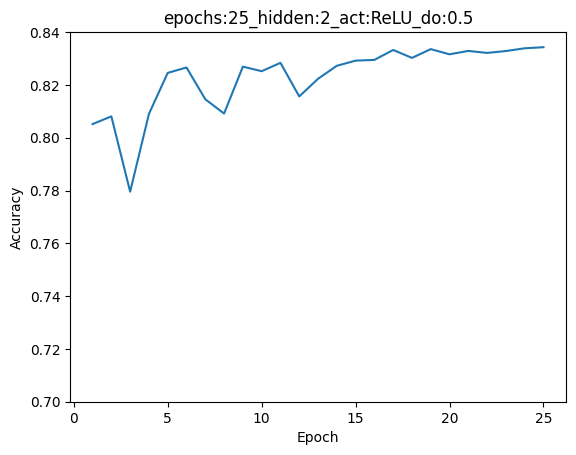

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'loss': 0.5686, 'learning_rate': 0.000968, 'epoch': 0.8}
{'eval_loss': 0.5140592455863953, 'eval_accuracy': 0.7894, 'eval_runtime': 12.1458, 'eval_samples_per_second': 2058.319, 'eval_steps_per_second': 51.458, 'epoch': 1.0}
{'loss': 0.497, 'learning_rate': 0.0009360000000000001, 'epoch': 1.6}
{'eval_loss': 0.4967557489871979, 'eval_accuracy': 0.80636, 'eval_runtime': 12.3758, 'eval_samples_per_second': 2020.069, 'eval_steps_per_second': 50.502, 'epoch': 2.0}
{'loss': 0.4996, 'learning_rate': 0.0009040000000000001, 'epoch': 2.4}
{'eval_loss': 0.48736485838890076, 'eval_accuracy': 0.81456, 'eval_runtime': 12.1911, 'eval_samples_per_second': 2050.679, 'eval_steps_per_second': 51.267, 'epoch': 3.0}
{'loss': 0.4882, 'learning_rate': 0.000872, 'epoch': 3.2}
{'loss': 0.4831, 'learning_rate': 0.00084, 'epoch': 4.0}
{'eval_loss': 0.5255762934684753, 'eval_accuracy': 0.77392, 'eval_runtime': 12.3937, 'eval_samples_per_second': 2017.15, 'eval_steps_per_second': 50.429, 'epoch': 4.0}
{'loss': 0.

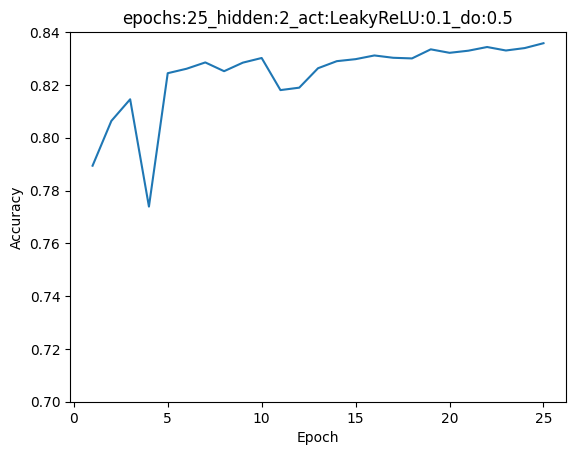

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'loss': 0.5634, 'learning_rate': 0.000968, 'epoch': 0.8}
{'eval_loss': 0.4986985921859741, 'eval_accuracy': 0.80624, 'eval_runtime': 11.1059, 'eval_samples_per_second': 2251.05, 'eval_steps_per_second': 56.276, 'epoch': 1.0}
{'loss': 0.5042, 'learning_rate': 0.0009360000000000001, 'epoch': 1.6}
{'eval_loss': 0.4884694218635559, 'eval_accuracy': 0.81676, 'eval_runtime': 11.3126, 'eval_samples_per_second': 2209.917, 'eval_steps_per_second': 55.248, 'epoch': 2.0}
{'loss': 0.4995, 'learning_rate': 0.0009040000000000001, 'epoch': 2.4}
{'eval_loss': 0.48208487033843994, 'eval_accuracy': 0.82104, 'eval_runtime': 11.625, 'eval_samples_per_second': 2150.529, 'eval_steps_per_second': 53.763, 'epoch': 3.0}
{'loss': 0.4885, 'learning_rate': 0.000872, 'epoch': 3.2}
{'loss': 0.4817, 'learning_rate': 0.00084, 'epoch': 4.0}
{'eval_loss': 0.4815753996372223, 'eval_accuracy': 0.82136, 'eval_runtime': 11.2772, 'eval_samples_per_second': 2216.862, 'eval_steps_per_second': 55.422, 'epoch': 4.0}
{'loss': 0

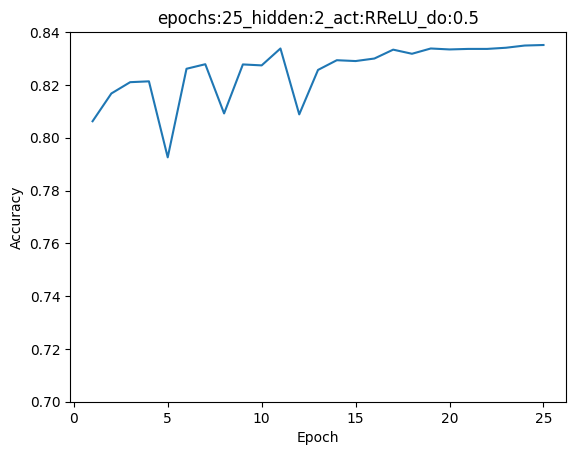

In [ ]:
activations = [("ReLU", nn.ReLU()), ("LeakyReLU:0.1", nn.LeakyReLU(0.1)), ("RReLU", nn.RReLU())]

for a_title, a_val in activations: 
  num_train_epochs=25
  num_hidden_layers=2
  title = f"epochs:{num_train_epochs}_hidden:{num_hidden_layers}_act:{a_title}_do:{0}"
  trainer = configure_model(num_train_epochs=num_train_epochs, num_hidden_layers=num_hidden_layers, dropout=0, activation=a_val)
  trainer.train()
  plot_accuracy(num_train_epochs, trainer, title)

## 5.e

In [ ]:
import random

best_trainer = do_trainers[0]
p, l, m = best_trainer.predict(small_eval_dataset)
p = torch.tensor(p)

idxs = []
all = list(range(len(l)))
random.shuffle(all)
for i in all:
  if (len(idxs) == 10):
    break
  if (int(torch.argmax(p[i])) != int(l[i])):
    idxs.append(i)

In [ ]:
for i in idxs:
  print(raw_datasets['test'][i])

{'text': 'Why is it that Canada can turn out decent to good movies in every genre, other then action? I caught Dragon Hunt on TV the other day and it was like a train wreck. I just could not change the channel, it\'s sheer stupidity sapped my willpower. Its pretty telling that the cast IMDb "credits" with this monstrosity apparently never worked again.<br /><br />Bad acting, bad writing, bad narration, bad music, bad hair, bad cinematography. It just goes on and on. The movie really has nothing to recommend it. If you\'re looking for bad action films to enjoy by laughing out, there are a tonne of other films that won\'t require you to scorch out your retinas afterwards.<br /><br />I hope this film didn\'t get money from the government for financing, otherwise I\'m never paying taxes again.', 'label': 0}
{'text': "The film is somewhat entertaining, but the greatest feature is Shalom Harlow's laughable performance. It has been 4 years since this movie was released and hopefully Harlow ha